# Churn Analysis with POO (Python Object-Oriented Programming)
This notebook demonstrates how to perform churn analysis using Python's object-oriented programming (POO) principles. We will create a class to encapsulate the data loading, preprocessing, and analysis steps.

In [34]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score)

import warnings
warnings.filterwarnings('ignore')

## ChurnPredictor Class
This class encapsulates the entire churn analysis process, including data loading, preprocessing, model training, and evaluation.

In [35]:
class ChurnPredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.pipeline = None
        self.X = self.y = None
        self.X_train = self.X_test = self.y_train = self.y_test = None
        self.y_pred = self.y_pred_proba = None
        self.cat_features = []
        self.num_features = []

    def load_and_prepare_data(self, target_column, drop_columns=[]):
        """
        Load and prepare the dataset for analysis.
        """
        try:
            df = pd.read_csv(self.file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"The file {self.file_path} was not found.")
        except Exception as e:
            raise Exception(f"Error loading the data: {str(e)}")

        if target_column not in df.columns:
            raise ValueError(f"Target column '{target_column}' not found in the dataset.")
        
        df.drop(columns=drop_columns, inplace=True)
        self.X = df.drop(columns=target_column)
        self.y = df[target_column]
        
        if df[target_column].dtype == 'object':
            self.y = self.y.map({'Yes': 1, 'No': 0})  

        self.cat_features = self.X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.num_features = self.X.select_dtypes(include=['int64', 'float64']).columns.tolist()

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        cat_transformer = OneHotEncoder(handle_unknown='ignore')
        num_transformer = StandardScaler()

        preprocessor = ColumnTransformer(transformers=[
                                                       ('cat', cat_transformer, self.cat_features),
                                                       ('num', num_transformer, self.num_features)
        ])

        self.pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('classifier', LogisticRegression(max_iter=1000))])

    def train(self):
        """
        Train the logistic regression model.
        """
        self.pipeline.fit(self.X_train, self.y_train)

    def predict(self):
        """
        Make predictions on the test set.
        """
        if self.pipeline is None:
            raise ValueError("Model has not been trained yet. Call train() first.")
        
        self.y_pred = self.pipeline.predict(self.X_test)
        self.y_pred_proba = self.pipeline.predict_proba(self.X_test)[:, 1]

    def evaluate(self):
        """
        Evaluate the model and return key performance metrics.
        """
        if self.y_pred is None:
            raise ValueError("Predictions have not been made yet. Call predict() first.")

        metrics = {
            'accuracy': accuracy_score(self.y_test, self.y_pred),
            'precision': precision_score(self.y_test, self.y_pred),
            'recall': recall_score(self.y_test, self.y_pred),
            'f1': f1_score(self.y_test, self.y_pred),
            'confusion_matrix': confusion_matrix(self.y_test, self.y_pred).tolist(),
            'classification_report': classification_report(self.y_test, self.y_pred)
        }
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        return metrics, fpr, tpr, roc_auc

    def find_best_threshold(self):
        """
        Find the best threshold for classification based on precision-recall trade-off.
        """
        if self.y_pred_proba is None:
            raise ValueError("Predictions have not been made yet. Call predict() first.")
        
        precisions, recalls, thresholds = precision_recall_curve(self.y_test, self.y_pred_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
        best_threshold_idx = np.argmax(f1_scores[:-1])  # Exclude the last threshold as it corresponds to no positive predictions
        best_threshold = thresholds[best_threshold_idx]

        return best_threshold

    def plot_precision_recall_f1_threshold(self):
        """
        Plot precision, recall, and F1 curves against different thresholds.
        """
        if self.y_pred_proba is None:
            raise ValueError("Predictions have not been made yet. Call predict() first.")
        
        precisions, recalls, thresholds = precision_recall_curve(self.y_test, self.y_pred_proba)
        
        # Calculate F1 scores more efficiently
        f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
        
        plt.figure(figsize=(8, 6))
        plt.plot(thresholds, precisions[:-1], color='blue', label='Precision')
        plt.plot(thresholds, recalls[:-1], color='red', label='Recall')
        plt.plot(thresholds, f1_scores, color='green', label='F1-score')
        
        best_threshold = self.find_best_threshold()
        plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
        
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision, Recall, and F1 Score vs Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, conf_matrix):
        """
        Plot the confusion matrix.
        :param conf_matrix: Confusion matrix to plot.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def plot_roc_curve(self, fpr, tpr, roc_auc):
        """
        Plot the ROC curve.
        :param fpr: False positive rate.
        :param tpr: True positive rate.
        :param roc_auc: Area under the ROC curve.
        """
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    def plot_precision_recall_f1_threshold(self):
        """ 
        Plot precision and recall curve.
        """
        if self.y_pred_proba is None:
            raise ValueError("Predictions have not been made yet. Call predict() first.")
        
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_pred_proba)
        
        # Calculate F1 scores for each threshold
        f1_scores = []
        for threshold in thresholds:
            y_pred = (self.y_pred_proba >= threshold).astype(int)
            f1 = f1_score(self.y_test, y_pred)
            f1_scores.append(f1)
        
        plt.figure(figsize=(8, 6))
        plt.plot(thresholds, precision[:-1], color='blue', label='Precision')
        plt.plot(thresholds, recall[:-1], color='red', label='Recall')
        plt.plot(thresholds, f1_scores, color='green', label='F1-score')
        
        best_threshold = self.find_best_threshold()
        plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
        
        plt.xlabel('Thresholds')
        plt.ylabel('Score')
        plt.title('Precision, Recall, and F1 Score vs Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_model(self, file_path='./data/churn_model.pkl'):
        """
        Save the trained model to a file.
        :param file_path: Path to save the model.
        """
        joblib.dump(self.pipeline, file_path)

    def load_model(self, file_path='./data/churn_model.pkl'):
        """
        Load a trained model from a file.
        :param file_path:
        """
        self.pipeline = joblib.load(file_path)
def get_model_metrics(self):
    """
    Get detailed model performance metrics.
    """
    if self.y_pred is None:
        raise ValueError("Predictions have not been made yet. Call predict() first.")
    
    metrics = {
        'accuracy': accuracy_score(self.y_test, self.y_pred),
        'precision': precision_score(self.y_test, self.y_pred),
        'recall': recall_score(self.y_test, self.y_pred),
        'f1': f1_score(self.y_test, self.y_pred),
        'confusion_matrix': confusion_matrix(self.y_test, self.y_pred).tolist(),
        'classification_report': classification_report(self.y_test, self.y_pred)
    }
    return metrics

## Example Usage
This section demonstrates how to use the `ChurnPredictor` class to perform churn analysis.

Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.70      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



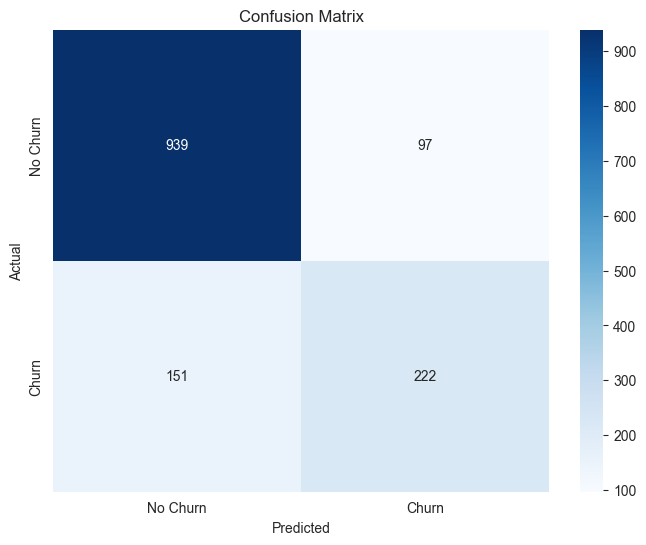

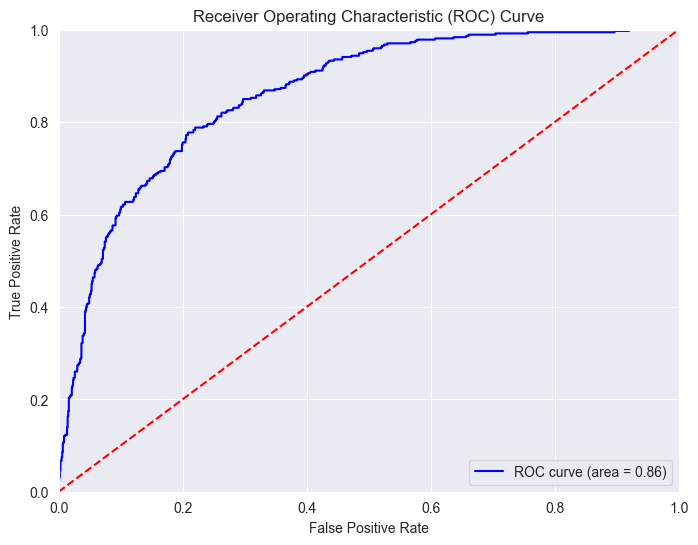

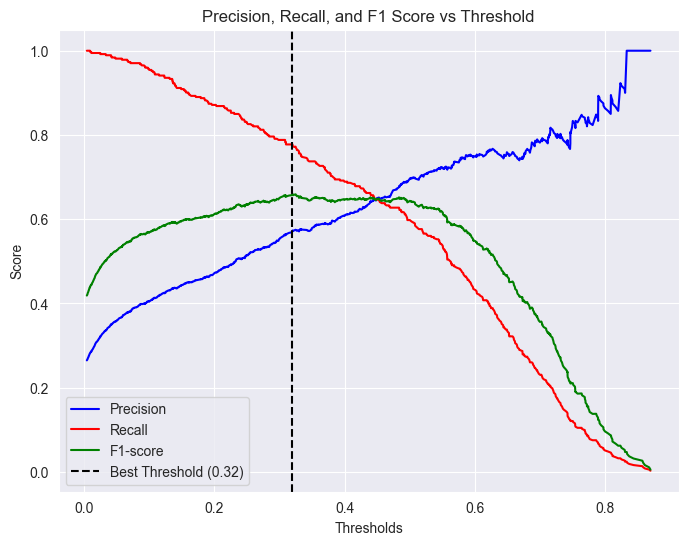

In [38]:
# Example usage of the ChurnPredictor class
churn_predictor = ChurnPredictor('../data/churn_data.csv')
churn_predictor.load_and_prepare_data(target_column='Churn', drop_columns=['customerID'])
churn_predictor.train()
churn_predictor.predict()
metrics, fpr, tpr, roc_auc = churn_predictor.evaluate()
print(f"Accuracy: {metrics['accuracy']:.2f}")
print("Classification Report:\n", metrics['classification_report'])
churn_predictor.plot_confusion_matrix(metrics['confusion_matrix'])
churn_predictor.plot_roc_curve(fpr, tpr, roc_auc)
churn_predictor.plot_precision_recall_f1_threshold()
churn_predictor.save_model()

# Interpretation of Results

- **Accuracy**: **0.82**
  The model correctly predicted 82% of the total observations. This is a solid overall performance, indicating that the model is generally effective. However, accuracy alone can be misleading in imbalanced datasets.

- **Confusion Matrix**:
  ```
  [[939, 97],
   [151, 222]]
  ```
  - **True Negatives (TN)**: 939 clients correctly predicted as not churning
  - **False Positives (FP)**: 97 clients wrongly predicted as churners
  - **False Negatives (FN)**: 151 clients who churned but were not predicted
  - **True Positives (TP)**: 222 clients correctly predicted as churners
  The model performs better at identifying clients who will **not churn** than those who will. The **false negatives remain important** and may represent lost opportunities to intervene.

- **Classification Report**:
  ```
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.70      0.60      0.64       373

   accuracy                            0.82      1409
   macro avg       0.78      0.75      0.76      1409
   weighted avg    0.82      0.82      0.82      1409
  ```
  - For class **0 (no churn)**, the model shows high precision and recall.
  - For class **1 (churn)**, precision is moderate (70%) but recall is lower (60%), indicating that **40% of actual churners are missed**.

- **Best Threshold**: **0.32**
  Rather than using the default threshold of 0.50, the analysis found that **0.32 maximizes the F1-score** and offers a better balance between precision and recall for the positive (churn) class.
  This threshold may be more appropriate in a business context where **identifying churners is critical**, even at the cost of some false positives.

- **Threshold Analysis Curve**:
  A graph of **precision, recall, and F1-score** across thresholds helped identify the optimal decision point. The curve revealed that **lowering the threshold improves recall** significantly while maintaining reasonable precision.

## **Conclusion**:
This model provides a strong starting point for churn prediction. With the use of a **custom threshold (0.32)**, it becomes more aligned with business goals, especially if the **cost of missing a churner is high**. Further improvements could be made with feature engineering, cost-sensitive training, or advanced models like ensemble methods.